In [1]:
#!pip install tensorflow
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Preparing The Data

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [5]:
print(data_dir)

/Users/alokbhardwaj/.keras/datasets/flower_photos


/Users/alokbhardwaj/.keras/datasets/flower_photos/roses/2888138918_402096c7fb.jpg


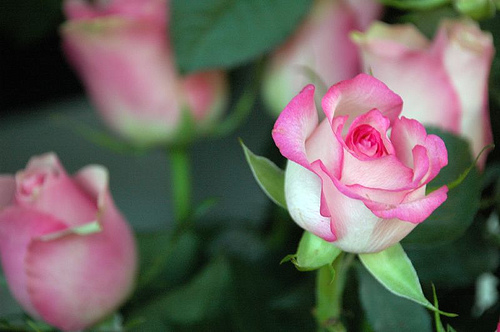

In [7]:
roses = list(data_dir.glob('roses/*'))
print(roses[49])
PIL.Image.open(str(roses[49]))

In [8]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2023-08-26 15:01:36.603303: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2023-08-26 15:01:50.710498: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


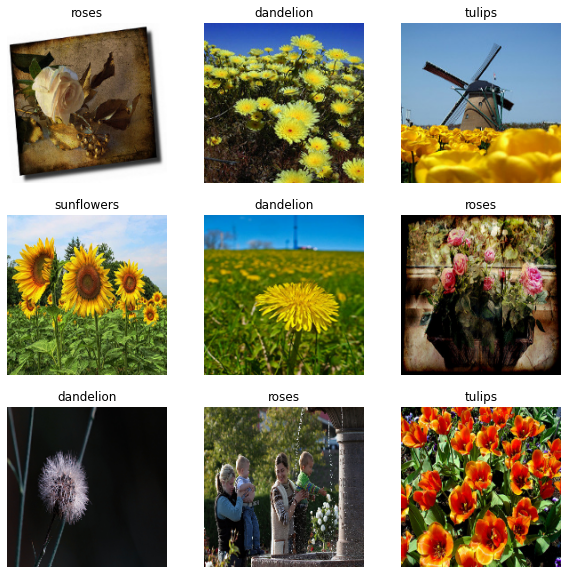

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Training The Model

In [12]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False   # freezing the layers i.e. freezing the weights

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
#resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
resnet_model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [15]:
epochs=5
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 306s 3s/step - loss: 1.2735 - accuracy: 0.6441 - val_loss: 0.3962 - val_accuracy: 0.8501
Epoch 2/5
92/92 [==============================] - 338s 4s/step - loss: 0.2728 - accuracy: 0.9054 - val_loss: 0.3734 - val_accuracy: 0.8706
Epoch 3/5
92/92 [==============================] - 325s 4s/step - loss: 0.1690 - accuracy: 0.9413 - val_loss: 0.5783 - val_accuracy: 0.8174
Epoch 4/5
92/92 [==============================] - 333s 4s/step - loss: 0.1059 - accuracy: 0.9681 - val_loss: 0.4103 - val_accuracy: 0.8624
Epoch 5/5
92/92 [==============================] - 310s 3s/step - loss: 0.0523 - accuracy: 0.9838 - val_loss: 0.4285 - val_accuracy: 0.8747


# Evaluating The Model

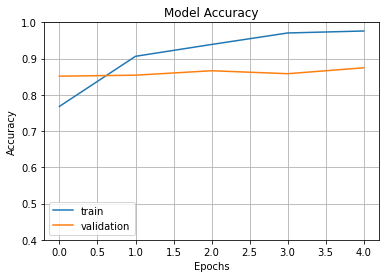

In [16]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


Model Loss

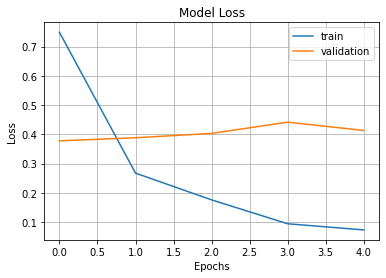

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [18]:
print ([roses[1]])

[PosixPath('/Users/alokbhardwaj/.keras/datasets/flower_photos/roses/5777669976_a205f61e5b.jpg')]


Making Predictions

In [19]:
#!pip install opencv-python

import os
os.sys.path

import cv2
image=cv2.imread(str(roses[0]))
print (image.shape)
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

(243, 500, 3)
(1, 180, 180, 3)


Prediction based on model

In [20]:
pred=resnet_model.predict(image)
print(pred)

[[7.8476169e-06 3.4009585e-07 9.7885758e-01 1.2243631e-06 2.1133112e-02]]


In [21]:
print (np.argmax(pred))
print (class_names)

2
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [22]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)
# PIL.Image.open(str(roses[1]))

The predicted class is roses
